# Interpolations

This section introduces two interpolation methods and demonstrates how `Rectified Flow` provides a user-friendly interface based on these examples.

If you're new to the Rectified Flow framework, we suggest starting with `train_2d_toys.ipynb`.

**Interpolation**

Given observed samples $X_0 \sim \pi_0$ and $X_1 \sim \pi_1$, we consider a class of *affine interpolations* $X_t$, which is defined as:

$$
X_t = \alpha_t \cdot X_0 + \beta_t \cdot X_1,
$$

where $ \alpha_t $ and $ \beta_t $ are time-dependent functions satisfying:
$$
\alpha_0 = \beta_1 = 0 \quad \text{and} \quad \alpha_1 = \beta_0 = 1.
$$


**Rectified Flow Velocity Field**

The *rectified flow velocity* induced by the interpolation process $\{X_t : t \in [0, 1]\}$ is defined as:

$$
v(z, t) = \mathbb{E}[ \dot{X}_t \mid X_t = z] = \arg \min_v \int_0^1 \mathbb{E} \left[\left\| \dot{\alpha}_t X_1 + \dot{\beta}_t X_0 - v(X_t, t) \right\|^2 \right] \, \mathrm{d}t
$$

where $ v(z, t) $ is the conditonal expectation of all $\dot X_t$ at $X_t=z$.

We call the process $\{Z_t\}$ the *rectified flow* induced from the interpolation $\{X_t\}$.

$$
Z_t = Z_0 + \int_0^t v(Z_t, t) \, \mathrm dt, \quad \forall t \in [0, 1], \quad Z_0 = X_0
$$


In the 2D toy example, we used the `straight` interpolation, where $\alpha_t = 1 - t$ and $\beta_t = t$, yields

$$
X_t = tX_1 + (1 - t)X_0, \quad \dot X_t = X_1 - X_0
$$

However, $\alpha_t$ and $\beta_t$ can actually be **any** time-dependent functions, as long as they satisfy $\alpha_0 = \beta_1 = 0$ and $\alpha_1 = \beta_0 = 1$. Let’s explore some alternative interpolation methods to see how they influence the behavior of the rectified flow.

In [2]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch.distributions as dist

from rectified_flow.utils import set_seed
from rectified_flow.datasets.toy_gmm import TwoPointGMM

from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.models.toy_mlp import MLPVelocityConditioned, MLPVelocity

set_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In this example, we use a 2D toy dataset consisting of:

- $\pi_0$: A standard 2D Gaussian distribution with mean of zeros and identity covariance matrix.
- $\pi_1$: A custom two-point Gaussian mixture model with centers located at $(15, 2)$ and a standard deviation of $0.3$

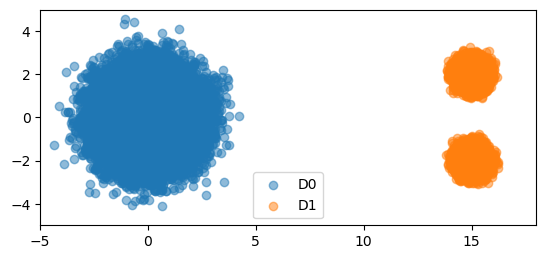

In [3]:
n_samples = 50000
pi_0 = dist.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
pi_1 = TwoPointGMM(x=15.0, y=2, std=0.3)
D0 = pi_0.sample([n_samples])
D1, labels = pi_1.sample_with_labels([n_samples])
labels.tolist()

plt.scatter(D0[:, 0].cpu().numpy(), D0[:, 1].cpu().numpy(), alpha=0.5, label='D0')
plt.scatter(D1[:, 0].cpu().numpy(), D1[:, 1].cpu().numpy(), alpha=0.5, label='D1')
plt.legend()
plt.xlim(-5, 18)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Let's consider three interpolation schemes:

**Straight Line Interpolation** (`"straight"` or `"lerp"`)
   
$$
\begin{align}
    \alpha_t & = t,       & \beta_t & = 1 - t \\
    \dot{\alpha}_t & = 1, & \dot{\beta}_t & = -1
\end{align}
$$
- As the name suggests, this interpolations follows a straight line connecting the source and target distributions.

**Spherical Interpolation** (`"spherical"` or `"slerp"`)

$$
\begin{align}
    \alpha_t & = \sin\left(\frac{\pi}{2} t\right), & \beta_t & = \cos\left(\frac{\pi}{2} t\right) \\
    \dot{\alpha}_t & = \frac{\pi}{2} \cos\left(\frac{\pi}{2} t\right), & \dot{\beta}_t & = -\frac{\pi}{2} \sin\left(\frac{\pi}{2} t\right)
\end{align}
$$

- This slerp spherical interpolation forms a curved trajectory using sine and cosine functions, note that in both cases $\alpha(0)=\beta(1)=1$, and $\alpha(1)=\beta(0)=0$

**DDIM Interpolation**

$$
\begin{align}
	\alpha_t &= \exp \left(- \frac{1}{4}a(1-t)^2-\frac 1 2b(1-t) \right), \quad \beta_t = \sqrt{1- \alpha_t^2}
\end{align}
$$
- With default values: $a=19.9, b=0.1$


These three interpolations construct paths to transport $\pi_0$ to $\pi_1$. However, we cannot "simulate" these paths from $X_0$ because:

- The updates at each position $X_t$ depend on the final state $X_1$, which is inaccessible at intermediate times ($t < 1$).

In the figure below, trajectories intersect at certain positions (around $X$-axis), indicating that there is **multiple possible diretions** to $\pi_1$. Such behavior makes it impossible to simulate using causal ODEs, as ODEs require a unique direction (or velocity) $v_t(X_t)$ for the given current state $(X_t, t)$.

In [4]:
from rectified_flow.flow_components.interpolation_solver import AffineInterp
from rectified_flow.utils import visualize_2d_trajectories_plotly

straight_interp = AffineInterp("straight")
spherical_interp = AffineInterp("spherical")

t = torch.linspace(0, 1, 1000)

idx = torch.randperm(n_samples)[:1000]
x_0 = D0[idx]
x_1 = D1[idx]

print(x_0.shape)

straight_interp_list = []
spherical_interp_list = []

for t in np.linspace(0, 1, 50):
	x_t_straight, dot_x_t_straight = straight_interp.forward(x_0, x_1, t)
	x_t_spherical, dot_x_t_spherical = spherical_interp.forward(x_0, x_1, t)
	straight_interp_list.append(x_t_straight)
	spherical_interp_list.append(x_t_spherical)

visualize_2d_trajectories_plotly(
	trajectories_dict={"straight interp": straight_interp_list, "spherical interp": spherical_interp_list},
	D1_gt_samples=D1[:5000],
	num_trajectories=100,
	title="Interpolated Trajectories Visualization",
)

torch.Size([1000, 2])


Now, let's train two rectified flows based on the two interpolation methods.

In [ ]:
def rf_trainer(rectified_flow, label = "loss", batch_size = 1024):
    model = rectified_flow.velocity_field
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    losses = []

    for step in range(5000):
        optimizer.zero_grad()
        idx = torch.randperm(n_samples)[:batch_size]
        x_0 = D0[idx].to(device)
        x_1 = D1[idx].to(device)

        loss = rectified_flow.get_loss(x_0, x_1)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if step % 200 == 0:
            print(f"Epoch {step}, Loss: {loss.item()}")

    plt.plot(losses, label=label)
    plt.legend()

In [ ]:
from rectified_flow.models.toy_mlp import MLPVelocity

straight_rf = RectifiedFlow(
    data_shape=(2,),
    velocity_field=MLPVelocity(2, hidden_sizes = [128, 128, 128]).to(device),
    interp=straight_interp,
    source_distribution=pi_0,
    device=device,
)

spherical_rf = RectifiedFlow(
    data_shape=(2,),
	velocity_field=MLPVelocity(2, hidden_sizes = [128, 128, 128]).to(device),
	interp=spherical_interp,
	source_distribution=pi_0,
	device=device,
)

rf_trainer(straight_rf, "straight interp")
rf_trainer(spherical_rf, "spherical interp")

Now that we have trained two rectified flows based on two different interpolation methods, let's visualize the trajectories to examine how the rectified flow effectively **"causalizes"** the interpolation process.

We begin by splitting $X_0 \sim \pi_0$ into two categories: points above and below the $X$-axis. We then use these subsets of $X_0$ to perform sampling with the rectified flows.

From the visualization, we can observe that the trajectories have been "causalized," meaning they are now "simulatable." Specifically, there are no intersections between trajectories, and the blue and pink dots evolve separately. Recall that the rectified flow learns the average direction at points of intersection using:

$$
v(z, t) = \mathbb{E}[\dot{X}_t \mid X_t = z].
$$

The figure also highlights this averaging effect, particularly around the $X$-axis, where the trajectories progress horizontally without intersecting.

In [ ]:
from rectified_flow.samplers import EulerSampler
from rectified_flow.utils import visualize_2d_trajectories_plotly

x_0 = straight_rf.sample_source_distribution(batch_size=500)
x_0_upper = x_0.clone()
x_0_upper[:, 1] = torch.abs(x_0_upper[:, 1])
x_0_lower = x_0.clone()
x_0_lower[:, 1] = -torch.abs(x_0_lower[:, 1])

euler_sampler_straight = EulerSampler(
    rectified_flow=straight_rf,
	num_steps=1000,
)

euler_sampler_spherical = EulerSampler(
    rectified_flow=spherical_rf,
	num_steps=1000,
)

straight_rf_list_upper = euler_sampler_straight.sample_loop(x_0=x_0_upper).trajectories
straight_rf_list_lower = euler_sampler_straight.sample_loop(x_0=x_0_lower).trajectories
spherical_rf_list_upper = euler_sampler_spherical.sample_loop(x_0=x_0_upper).trajectories
spherical_rf_list_lower = euler_sampler_spherical.sample_loop(x_0=x_0_lower).trajectories

visualize_2d_trajectories_plotly(
    trajectories_dict={
        "straight rf upper": straight_rf_list_upper,
		"straight rf lower": straight_rf_list_lower,
		"spherical rf upper": spherical_rf_list_upper,
		"spherical rf lower": spherical_rf_list_lower,
    },
    D1_gt_samples=D1[:1000],
    num_trajectories=100,
	title="1-Rectified Flow: Causalized ODE (Layered Vertically)",
)

Now, let's also divide the interpolated trajectories into two parts: those above the $X$-axis and those below it. In this figure, we can observe that the blue and pink dots are mixed together, and the trajectories are intertwined around the $X$-axis.

In [ ]:
straight_interp_upper_list = []
straight_interp_lower_list = []
spherical_interp_upper_list = []
spherical_interp_lower_list = []

upper_indices_straight = (straight_interp_list[0][:, 1] >= 0) 
lower_indices_straight = (straight_interp_list[0][:, 1] < 0)

upper_indices_spherical = (spherical_interp_list[0][:, 1] >= 0)
lower_indices_spherical = (spherical_interp_list[0][:, 1] < 0)

for t in range(len(straight_interp_list)):
    straight = straight_interp_list[t]
    spherical = spherical_interp_list[t]
    
    straight_interp_upper_list.append(straight[upper_indices_straight])
    straight_interp_lower_list.append(straight[lower_indices_straight])
    
    spherical_interp_upper_list.append(spherical[upper_indices_spherical])
    spherical_interp_lower_list.append(spherical[lower_indices_spherical])

        
visualize_2d_trajectories_plotly(
    trajectories_dict={
		"straight interp upper": straight_interp_upper_list,
		"straight interp lower": straight_interp_lower_list,
		"spherical interp upper": spherical_interp_upper_list,
		"spherical interp lower": spherical_interp_lower_list,
	},
	D1_gt_samples=D1[:1000],
	num_trajectories=100,
	title="Interpolated Trajectories Visualization (Layered Vertically)",
)

# Samplers

`Rectified Flow` also offers several off-the-shelf `Sampler`s for exploration and study. These prebuilt Samplers are straightforward to use. 

In [ ]:
from rectified_flow.samplers import rf_samplers_dict

for key, rf_sampler in rf_samplers_dict.items():
	print(f"{key}: {rf_sampler}")

## Euler Sampler

The **Euler Sampler** uses a simple integration rule:

$$
X_{t + \Delta t} = X_t + \Delta t \cdot v(X_t, t)
$$

where $v(X_t, t)$ is the velocity at the current state and time.

To implement the **Euler Sampler**, we inherit from the `Sampler` base class and override its `step` method. The base class handles time-stepping and trajectory recording, so we only need to define how the state $x_t$ is updated in each step:

In [ ]:
from rectified_flow.samplers.base_sampler import Sampler

class MyEulerSampler(Sampler):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def step(self, **model_kwargs):
        # Extract the current time, next time point, and current state
        t, t_next, x_t = self.t, self.t_next, self.x_t
        
        # Compute the velocity field at the current state and time
        v_t = self.rectified_flow.get_velocity(x_t=x_t, t=t, **model_kwargs)
        
        # Update the state using the Euler formula
        self.x_t = x_t + (t_next - t) * v_t
        
euler_sampler = MyEulerSampler(
    rectified_flow=straight_rf,
    num_steps=50,
    num_samples=100,
)

# Sample method 1)
# Will use the default num_steps and num_samples previously set in the Sampler class
traj1 = euler_sampler.sample_loop(seed=233)

# Sample method 2)
# We can pass in a custom x_0 to sample from
set_seed(233)
x_0 = straight_rf.sample_source_distribution(batch_size=100)
traj2 = euler_sampler.sample_loop(x_0=x_0)

# Sample method 3)
# If we pass in num_steps and num_samples, it will override the default values
traj3 = euler_sampler.sample_loop(seed=233, num_steps=50, num_samples=100)

# three trajectories are the same
visualize_2d_trajectories_plotly(
    trajectories_dict={
        "traj1": traj1.trajectories,
        "traj2": traj2.trajectories,
        "traj3": traj3.trajectories,
    },
    D1_gt_samples=D1[:1000],
    num_trajectories=100,
    title="My Euler Sampler",
)

## AffineInterp Solver

Let us introduce a key feature provided by the `AffineInterp` class.

The interpolation process is governed by two equations:

$$
\begin{align}
    X_t &= \alpha_t \cdot X_1 + \beta_t \cdot X_0, \\
    \dot{X}_t &= \dot{\alpha}_t \cdot X_1 + \dot{\beta}_t \cdot X_0,
\end{align}
$$

where $X_t$ represents the interpolated state at time $t$, and $\dot{X}_t$ is its time derivative.

Given any two of the variables $X_0, X_1, X_t, \dot{X}_t$, the remaining two variables can be uniquely determined for a specific time $t$. 

The `AffineInterp` class provide a `solve` function, which simplifies equation solving by incorporating precomputed symbolic solvers for all possible combinations of known and unknown variables, making it straightforward to compute the missing variables as needed.

In [ ]:
x_0 = straight_rf.sample_source_distribution(batch_size=500)
x_1 = D1[:500].to(device)
t = straight_rf.sample_train_time(batch_size=500)
x_t, dot_x_t = straight_rf.get_interpolation(x_0, x_1, t)

# Given x_t and dot_x_t, solve for x_0 and x_1
result = straight_rf.interp.solve(t, x_t=x_t, dot_x_t=dot_x_t)
x_1_pred = result.x_1
x_0_pred = result.x_0

assert torch.allclose(x_0, x_0_pred, atol=1e-4)
assert torch.allclose(x_1, x_1_pred, atol=1e-4)

## Curved Euler Sampler

Starting from the current state $(X_t, t)$, the Curved Euler Sampler first uses the velocity model to compute the current velocity $v_t(X_t)$. 

The interpolation solver is then employed to estimate $\hat{X}_0$ and $\hat{X}_1$ for $X_t$.

After obtaining $\hat{X}_0$ and $\hat{X}_1$, the sampler performs a single Euler step along the curved trajectory defined by the two predictions to compute the next state $X_{t + \Delta_t}$:

$$
X_{t + \Delta_t} = \alpha(t + \Delta t) \cdot \hat{X}_1 + \beta(t + \Delta t) \cdot \hat{X}_0
$$

In [ ]:
from rectified_flow.samplers import CurvedEulerSampler

curved_euler_sampler_sphere = CurvedEulerSampler(
    rectified_flow=spherical_rf,
	num_steps=10,
	num_samples=100,
)

curved_euler_sampler_straight = CurvedEulerSampler(
    rectified_flow=straight_rf,
	num_steps=10,
	num_samples=100,
)

visualize_2d_trajectories_plotly(
    trajectories_dict={
		"straight": curved_euler_sampler_straight.sample_loop(seed=0).trajectories, 
		"spherical": curved_euler_sampler_sphere.sample_loop(seed=0).trajectories,
	},
	D1_gt_samples=D1[:1000],
	num_trajectories=100,
	title="Curved Euler Sampler",
)

## Noise Refresh Sampler

This example demonstrates how to create a custom sampler that refreshes the noise component at each step. 

At each point, the sampler predicts the noise component $\hat{X}_0$ and refreshes it by blending it with new noise, using the formula:

$$
X_0' = \sqrt{1 - \eta^2} \cdot \hat{X}_0 + \eta \cdot \epsilon,
$$

where $\eta$ is the noise replacement rate, and $\epsilon$ is a random noise sample. 

In [ ]:
class MyNoiseRefreshSampler(Sampler):
    def __init__(self, noise_replacement_rate = lambda t: 0.5, **kwargs):
        super().__init__(**kwargs)
        self.noise_replacement_rate = noise_replacement_rate
        assert (self.rectified_flow.independent_coupling and self.rectified_flow.is_pi_0_zero_mean_gaussian), \
            'pi0 must be a zero mean gaussian and must use indepdent coupling'

    def step(self, **model_kwargs):
        t, t_next, x_t = self.t, self.t_next, self.x_t
        v_t = self.rectified_flow.get_velocity(x_t=x_t, t=t, **model_kwargs)

        # Given x_t and dot_x_t = vt, find the corresponding endpoints x_0 and x_1
        self.rectified_flow.interp.solve(t, x_t=x_t, dot_x_t=v_t)
        x_1_pred = self.rectified_flow.interp.x_1
        x_0_pred = self.rectified_flow.interp.x_0

        # Randomize x_0_pred by replacing part of it with new noise
        noise = self.rectified_flow.sample_source_distribution(self.num_samples)

        noise_replacement_factor = self.noise_replacement_rate_t
        x_0_pred_refreshed = (
            (1 - noise_replacement_factor**2)**0.5 * x_0_pred +
            noise * noise_replacement_factor
        )

        # Interpolate to find x_t at t_next
        self.rectified_flow.interp.solve(t_next, x_0=x_0_pred_refreshed, x_1=x_1_pred)
        self.x_t = self.rectified_flow.interp.x_t
        
noise_refresh_sampler = MyNoiseRefreshSampler(
    rectified_flow=spherical_rf,
    num_steps=50,
    num_samples=500,
)

visualize_2d_trajectories_plotly(
    trajectories_dict={
        "spherical": noise_refresh_sampler.sample_loop(seed=0).trajectories,
    },
    D1_gt_samples=D1[:1000],
    num_trajectories=100,
    title="Noise Refresh Sampler",
)

### SDE sampler


In [ ]:
from rectified_flow.samplers import SDESampler

sde_sampler_sphere = SDESampler(
    rectified_flow=spherical_rf,
	num_steps=50,
	num_samples=500,
)

sde_sampler_straight = SDESampler(
    rectified_flow=straight_rf,
	num_steps=50,
	num_samples=500,
)

visualize_2d_trajectories_plotly(
    trajectories_dict={
		"straight": sde_sampler_sphere.sample_loop(seed=0).trajectories, 
		"spherical": sde_sampler_straight.sample_loop(seed=0).trajectories,
	},
	D1_gt_samples=D1[:1000],
	num_trajectories=100,
	title="SDE Sampler",
)